In [1]:
install_mapie=True
if install_mapie:
    import os
    os.system('pip install mapie')

In [2]:
# !pip install tensorflow-datasets 

In [3]:
import random
import warnings
from typing import List, Tuple, Union, Dict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from sklearn.metrics import  accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from mapie.metrics import classification_coverage_score
from mapie.classification import MapieClassifier

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
SPACE_BETWEEN_LABELS = 2.5
SPACE_IN_SUBPLOTS = 4.0
FONT_SIZE = 18

## 1. Data loading

The Cifar10 dataset is downloaded from the Tensorflow Datasets library. The training set is then splitted into a training, validation and a calibration set which will be used as follow:

- Training set: used to train our neural network.
- Validation set: used to check that our model is not overfitting.
- Calibration set: used to calibrate the conformal scores in :class:mapie.classification.MapieClassifier

In [5]:
def train_valid_calib_split(
    X: np.ndarray,
    y: np.ndarray,
    calib_size: float = .1,
    val_size: float = .33,
    random_state: int = 42

) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Create calib and valid datasets from the train dataset.
    
    Parameters
    ----------
    X: np.ndarray of shape (n_samples, width, height, n_channels)
        Images of the dataset.
    
    y: np.ndarray of shape (n_samples, 1):
        Label of each image.
    
    calib_size: float
        Percentage of the dataset X to use as calibration set.
    
    val_size: float
        Percentage of the dataset X (minus the calibration set)
        to use as validation set.
    
    random_state: int
        Random state to use to split the dataset.
        
        By default 42.
    
    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
    of shapes: 
    (n_samples * (1 - calib_size) * (1 - val_size), width, height, n_channels),
    (n_samples * calib_size, width, height, n_channels),
    (n_samples * (1 - calib_size) * val_size, width, height, n_channels),
    (n_samples * (1 - calib_size) * (1 - val_size), 1),
    (n_samples * calib_size, 1),
    (n_samples * (1 - calib_size) * val_size, 1).
    
    """
    X_train, X_calib, y_train, y_calib = train_test_split(
        X, y,
        test_size=calib_size,
        random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=val_size,
        random_state=random_state
    )
    return X_train, X_calib, X_val, y_train, y_calib, y_val

In [6]:
def load_data() -> Tuple[
    Tuple[np.ndarray, np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray, np.ndarray],
    Tuple[np.ndarray, np.ndarray, np.ndarray],
    List
]:
    """
    Load cifar10 Dataset and return train, valid, calib, test datasets
    and the names of the labels
    
    
    Returns
    -------
    Tuple[
        Tuple[np.ndarray, np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray, np.ndarray],
        List
    ]
    """
    dataset, info = tfds.load(
        "cifar10",
        batch_size=-1,
        as_supervised=True,
        with_info=True
    )
    
    # print(info.features.keys())
    # label_names = info.features['lac'].names
    label_names = info.features['label'].names

    dataset = tfds.as_numpy(dataset)
    X_train, y_train = dataset['train']
    X_test, y_test = dataset['test']
    X_train, X_calib, X_val, y_train, y_calib, y_val = train_valid_calib_split(
        X_train,
        y_train
    )

    X_train = X_train/255.
    X_val = X_val/255.

    X_calib = X_calib/255.
    X_test = X_test/255.

    y_train_cat = tf.keras.utils.to_categorical(y_train)
    y_val_cat = tf.keras.utils.to_categorical(y_val)
    y_calib_cat = tf.keras.utils.to_categorical(y_calib)
    y_test_cat = tf.keras.utils.to_categorical(y_test)

    train_set = (X_train, y_train, y_train_cat)
    val_set = (X_val, y_val, y_val_cat)
    calib_set = (X_calib, y_calib, y_calib_cat)
    test_set = (X_test, y_test, y_test_cat)

    return train_set, val_set, calib_set, test_set, label_names

In [7]:
def inspect_images(
    X: np.ndarray,
    y: np.ndarray,
    num_images: int, 
    label_names: List
) -> None:
    """
    Load a sample of the images to check that images
    are well loaded.
    
    Parameters
    ----------
    X: np.ndarray of shape (n_samples, width, height, n_channels)
        Set of images from which the sample will be taken.
    
    y: np.ndarray of shape (n_samples, 1)
        Labels of the iamges of X.
    
    num_images: int
        Number of images to plot.
        
    label_names: List
        Names of the different labels
    
    """

    _, ax = plt.subplots(
        nrows=1,
        ncols=num_images,
        figsize=(2*num_images, 2)
    )

    indices = random.sample(range(len(X)), num_images)

    for i, indice in enumerate(indices):
        ax[i].imshow(X[indice])
        ax[i].set_title(label_names[y[indice]])
        ax[i].axis("off")
    plt.show()

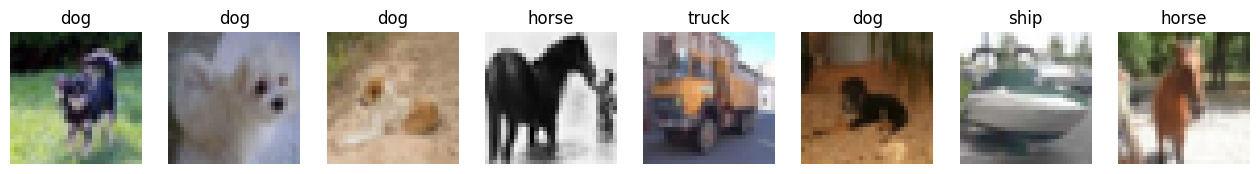

In [8]:
train_set, val_set, calib_set, test_set, label_names = load_data()
(X_train, y_train, y_train_cat) = train_set 
(X_val, y_val, y_val_cat) = val_set 
(X_calib, y_calib, y_calib_cat) = calib_set 
(X_test, y_test, y_test_cat) = test_set 
inspect_images(X=X_train, y=y_train, num_images=8, label_names=label_names)

## Definition and training of the the neural network
We define a simple convolutional neural network with the following architecture :
- 2 blocks of Convolution/Maxpooling
- Flatten the images
- 3 Dense layers
- The output layer with 10 neurons, corresponding to our 10 classes

This simple architecture, based on the VGG16 architecture with its succession of convolutions and maxpooling aims at achieving a reasonable accuracy score and a fast training. The objective here is not to obtain a perfect classifier.

In [9]:
def get_model(
    input_shape: Tuple, loss: tfk.losses,
    optimizer: tfk.optimizers, metrics: List[str]
) -> Sequential:
    """
    Compile CNN model.
    
    Parameters
    ----------
    input_shape: Tuple
        Size of th input images.
    
    loss: tfk.losses
        Loss to use to train the model.
    
    optimizer: tfk.optimizer
        Optimizer to use to train the model.
    
    metrics: List[str]
        Metrics to use evaluate model training.
    
    Returns
    -------
    Sequential
    """
    model = Sequential([
        Conv2D(input_shape=input_shape, filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## 3. Training the algorithm with a custom class called TensorflowToMapie

As MAPIE asks for a model with fit, predict_proba, predict class attributes and the information about whether or not the model is fitted.

In [10]:
class TensorflowToMapie():
    """
    Class that aimes to make compatible a tensorflow model
    with MAPIE. To do so, this class create fit, predict,
    predict_proba and _sklearn_is_fitted_ attributes to the model.
    
    """

    def __init__(self) -> None:
        self.pred_proba = None
        self.trained_ = False
        

    def fit(
        self, model: Sequential,
        X_train: np.ndarray, y_train: np.ndarray,
        X_val: np.ndarray, y_val: np.ndarray
    ) -> None:
        """
        Train the keras model.
        
        Parameters
        ----------
        model: Sequential
            Model to train.
            
        X_train: np.ndarray of shape (n_sample_train, width, height, n_channels)
            Training images.
        
        y_train: np.ndarray of shape (n_samples_train, n_labels)
            Training labels.
        
        X_val: np.ndarray of shape (n_sample_val, width, height, n_channels)
            Validation images.
        
        y_val: np.ndarray of shape (n_samples_val, n_labels)
            Validation labels.
        
        """
        
        early_stopping_monitor = EarlyStopping(
                    monitor='val_loss',
                    min_delta=0,
                    patience=10,
                    verbose=0,
                    mode='auto',
                    baseline=None,
                    restore_best_weights=True
                    )
        model.fit(
                    X_train, y_train, 
                    batch_size=64, 
                    validation_data=(X_val, y_val), 
                    epochs=20, callbacks=[early_stopping_monitor]
                )
        
        self.model = model
        self.trained_ = True
        self.classes_ = np.arange(model.layers[-1].units)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Returns the predicted probabilities of the images in X.
        
        Paramters:
        X: np.ndarray of shape (n_sample, width, height, n_channels)
            Images to predict.
        
        Returns:
        np.ndarray of shape (n_samples, n_labels)
        """
        preds = self.model.predict(X)
          
        return preds

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Give the label with the maximum softmax for each image.
        
        Parameters
        ---------
        X: np.ndarray of shape (n_sample, width, height, n_channels)
            Images to predict
            
        Returns:
        --------
        np.ndarray of shape (n_samples, 1)
        """
        pred_proba = self.predict_proba(X)
        pred = (pred_proba == pred_proba.max(axis=1)[:, None]).astype(int)
        return pred

    def __sklearn_is_fitted__(self):
        if self.trained_:
            return True
        else:
            return False

In [11]:
model = get_model(
    input_shape=(32, 32, 3), 
    loss=CategoricalCrossentropy(), 
    optimizer=Adam(), 
    metrics=['accuracy']
)

In [12]:
cirfar10_model = TensorflowToMapie()
cirfar10_model.fit(model, X_train, y_train_cat, X_val, y_val_cat)

Epoch 1/20
472/472 [==============================] - 23s 46ms/step - loss: 1.7273 - accuracy: 0.3569 - val_loss: 1.4939 - val_accuracy: 0.4480
Epoch 2/20
472/472 [==============================] - 23s 48ms/step - loss: 1.3926 - accuracy: 0.4951 - val_loss: 1.3932 - val_accuracy: 0.4863
Epoch 3/20
472/472 [==============================] - 23s 49ms/step - loss: 1.2305 - accuracy: 0.5576 - val_loss: 1.2353 - val_accuracy: 0.5499
Epoch 4/20
472/472 [==============================] - 31s 66ms/step - loss: 1.1078 - accuracy: 0.6053 - val_loss: 1.0908 - val_accuracy: 0.6110
Epoch 5/20
472/472 [==============================] - 26s 55ms/step - loss: 1.0044 - accuracy: 0.6387 - val_loss: 1.1066 - val_accuracy: 0.6076
Epoch 6/20
472/472 [==============================] - 24s 50ms/step - loss: 0.9180 - accuracy: 0.6761 - val_loss: 1.0241 - val_accuracy: 0.6391
Epoch 7/20
472/472 [==============================] - 24s 51ms/step - loss: 0.8552 - accuracy: 0.6956 - val_loss: 0.9609 - val_accuracy:

In [13]:
y_true = label_binarize(y=y_test, classes=np.arange(max(y_test)+1))
y_pred_proba = cirfar10_model.predict_proba(X_test)
y_pred = cirfar10_model.predict(X_test)

313/313 [==============================] - 2s 5ms/step


## Prediction of hte prediction sets

We will now estimate the prediction sets with the five conformal methods implemented in :class: mapie.classification.MapieClassifier for a range of confidence levels between 0 and 1

In [18]:
method_params = {
    "naive": ("naive", False),
    "score": ("score",False),
    "lac": ("lac",False),
    "cumulated_score": ("cumulated_score",False),
    "aps": ("aps", True),
    "raps": ("raps", False),
    "top_k": ("top_k", False),
}

In [19]:
method_params

{'naive': ('naive', False),
 'score': ('score', False),
 'lac': ('lac', False),
 'cumulated_score': ('cumulated_score', False),
 'aps': ('aps', True),
 'raps': ('raps', False),
 'top_k': ('top_k', False)}

In [20]:
y_preds, y_pss = {}, {}
alphas = np.arange(0.01, 1, 0.01)

for name, (method, include_last_label) in method_params.items():
    mapie = MapieClassifier(estimator=cirfar10_model, method=method, cv="prefit", random_state=42) 
    mapie.fit(X_calib, y_calib)
    y_preds[name], y_pss[name] = mapie.predict(X_test, alpha=alphas, include_last_label=include_last_label)

313/313 [==============================] - 2s 7ms/step


Let us now estimate the number of null prediction sets, marginal coverages, and averaged prediction set sizes obtained with the different methods for all confidence levels and for a confidence level 90%

In [21]:
def count_null_set(y: np.ndarray) -> int:
    """
    Count the number of empty prediction sets.
    
    Parameters
    ----------
    y: np.ndarray of shape (n_sample, )
    
    Returns
    -------
    int
    """
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count

In [22]:
nulls, coverages, accuracies, sizes = {}, {}, {}, {}
for name, (method, include_last_label) in method_params.items():
    accuracies[name] = accuracy_score(y_true, y_preds[name])
    nulls[name] = [
        count_null_set(y_pss[name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[name] = [
        classification_coverage_score(
            y_test, y_pss[name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    sizes[name] = [
        y_pss[name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]

In [23]:
coverage_90 = {method: coverage[9] for method, coverage in coverages.items()}
null_90 = {method: null[9] for method, null in nulls.items()}
width_90 = {method: width[9] for method, width in sizes.items()}
y_ps_90 = {method: y_ps[:, :, 9] for method, y_ps in y_pss.items()}

Let's now look at the marginal coverages, number of null prediction sets, and the average size of prediction sets for a confidence level of 90%

In [25]:
summary_df = pd.concat(
    [
        pd.Series(coverage_90),
        pd.Series(null_90),
        pd.Series(width_90)
    ],
    axis=1,
    keys=["Coverages", "Number of null sets", "Average prediction set sizes"]
).round(3)

summary_df

,Coverages,Number of null sets,Average prediction set sizes
naive,0.830,0,1.868
score,0.904,0,2.218
lac,0.904,0,2.218
cumulated_score,0.859,0,2.096
aps,0.943,0,2.826
raps,0.873,0,2.168
top_k,0.910,0,3.000
